## Quick check to see how frequently SpO2 drops below 80%.
### Summary:
- It is extremely uncommon.  
- There were only 16 measurements (out of 156,408) in the 26 days that were less than 80.  
- Measurements in the low 90s are much more common.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.api as sm
from statsmodels.discrete.discrete_model import Logit
from sklearn import preprocessing

import warnings
warnings.filterwarnings("ignore")

sns.set(style="ticks")
sns.set_context(context="talk")

In [2]:
infile = "/Users/kmcmanus/Documents/classes/digitalhealth_project/data/formatted_data/20200628_sleep_pos_5S_cleaned.csv"
df = pd.read_csv(infile, index_col='datetime', parse_dates=True, infer_datetime_format=True)
df["sleep_night"] = pd.to_datetime(df["sleep_night"])
df = df[(~df["Orientation"].isna() | ~df["SpO2(%)"].isna())]
print("Total # rows: {}".format(df.shape[0]))

Total # rows: 156424


In [3]:
df.describe()

,Orientation,Inclination,SpO2(%),Pulse Rate(bpm),Motion,Vibration,ODI,orient_bin,low_oxygen,hour,complete_hour,complete_night,time_since_pos_start
count,100827.000000,100827.000000,156424.000000,156424.000000,156424.000000,156424.000000,156411.000000,100827.000000,156424.000000,156424.000000,156424.000000,156424.000000,156424.000000
mean,-15.725180,92.354492,95.534912,62.027087,1.131246,0.085102,0.018739,0.138663,0.004462,9.291579,0.520125,0.975432,105.193359
std,73.536082,17.457866,1.842711,4.538416,7.261719,3.299377,0.135603,0.829362,0.066651,9.396579,0.499596,0.154804,154.062962
min,-179.630000,46.460000,71.000000,47.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,-79.740000,76.740000,95.000000,59.000000,0.000000,0.000000,0.000000,-1.000000,0.000000,2.000000,0.000000,1.000000,1.000000
50%,-14.530000,95.150000,96.000000,61.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,1.000000,39.000000
75%,65.350000,106.130000,97.000000,65.000000,0.000000,0.000000,0.000000,1.000000,0.000000,21.000000,1.000000,1.000000,150.000000
max,179.510000,178.910000,99.000000,96.000000,148.000000,128.000000,1.000000,1.000000,1.000000,23.000000,1.000000,1.000000,1115.000000


In [4]:
# How many days I have measurements for at least sleep position OR O2.
dates = np.unique(df["sleep_night"])
dates = [pd.Timestamp(date) for date in dates]
print("Number of dates: {}".format(len(dates)))

Number of dates: 26


In [5]:
# Add indicator for O2 < 80
df["below_80"] = 0
df.loc[(df["SpO2(%)"] < 80), "below_80"] = 1
df["below_80"].value_counts()

0    156408
1        16
Name: below_80, dtype: int64

In [6]:
df[df["below_80"] == 1]

,Orientation,Inclination,sleep_night,SpO2(%),Pulse Rate(bpm),Motion,Vibration,ODI,orient_bin,low_oxygen,hour,complete_hour,complete_night,time_since_pos_start,below_80
datetime,,,,,,,,,,,,,,,
2020-04-22 22:19:30,NaN,NaN,2020-04-22,79.0,81.0,0.0,0.0,1.0,NaN,1,22,0,1,1,1
2020-04-27 03:33:20,NaN,NaN,2020-04-26,78.0,73.0,0.0,0.0,1.0,NaN,1,3,0,1,1,1
2020-04-27 03:33:25,NaN,NaN,2020-04-26,78.0,72.0,0.0,0.0,1.0,NaN,1,3,0,1,1,1
2020-04-28 05:41:15,NaN,NaN,2020-04-27,78.0,73.0,0.0,0.0,1.0,NaN,1,5,0,1,1,1
2020-04-28 05:41:20,NaN,NaN,2020-04-27,75.0,74.0,0.0,0.0,1.0,NaN,1,5,0,1,1,1
2020-04-28 05:41:25,NaN,NaN,2020-04-27,73.0,75.0,0.0,0.0,1.0,NaN,1,5,0,1,1,1
2020-04-28 05:41:30,NaN,NaN,2020-04-27,71.0,75.0,0.0,0.0,1.0,NaN,1,5,0,1,1,1
2020-04-28 05:41:35,NaN,NaN,2020-04-27,72.0,75.0,0.0,0.0,1.0,NaN,1,5,0,1,1,1
2020-05-01 23:27:35,NaN,NaN,2020-05-01,78.0,79.0,0.0,128.0,1.0,NaN,1,23,0,1,1,1


Text(0.5, 1.0, 'Dist of SpO2(%) over all measurements')

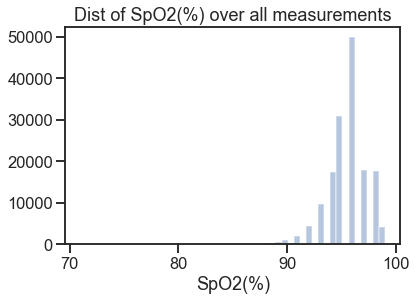

In [8]:
ax = sns.distplot(df["SpO2(%)"], kde=False)
ax.set_title("Dist of SpO2(%) over all measurements")